In [1]:
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import csv
import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

In [2]:
import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline 

In [3]:
def load_image_into_numpy_array(path):
    
    image = Image.open(path)
    (im_width, im_height) = image.size
    
    return np.array(image.getdata()).reshape((im_height, im_width,3)).astype(np.uint8) # Reshape is needed as the original numpy array is of shape (545920, 3)
    

In [4]:
def plot_detections(image_np, boxes, classes, scores, category_index,
                   figsize=(12,16), image_name=None):
    
    image_np_with_annotations = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_annotations, boxes, classes, scores, 
    category_index, use_normalized_coordinates=True,
    min_score_thresh=0.8)
    
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)

In [5]:
path_to_csv = "D:\\Technical Education\\Kotlin_Resources\\Machine_Learning_Apps\\Sign Language App\\test\\_annotations.csv"
train_image_dir = "D:\\Technical Education\\Kotlin_Resources\\Machine_Learning_Apps\\Sign Language App\\test\\"



In [6]:
os.chdir(train_image_dir)

In [ ]:
"""gt_boxes = []
train_images_np = []
gt_truth =[]

for file in glob.glob("*.jpg"):
    train_images_np.append(load_image_into_numpy_array(os.path.join(train_image_dir, file)))
    with open(path_to_csv, encoding="utf8") as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        lc = 0
        for row in csv_reader:
            if lc==0:
                lc = lc + 1
            else:
                if file == row[0]:
                    gt_boxes.append([row[4], row[5], row[6], row[7]])
                    gt_truth.append(row[3])
                    break
        
"""    

In [7]:
train_images_np = []


for file in glob.glob("*.jpg"):
    train_images_np.append(load_image_into_numpy_array(os.path.join(train_image_dir, file)))

In [8]:
gt_boxes = []
sign_lang_csv = pd.read_csv(path_to_csv)

sign_lang_csv.sort_values(sign_lang_csv.columns[0], 
                    axis=0,
                    inplace=True)

xmin = sign_lang_csv['xmin'].tolist()
ymin = sign_lang_csv['ymin'].tolist()
xmax = sign_lang_csv['xmax'].tolist()
ymax = sign_lang_csv['ymax'].tolist()

gt_truth = sign_lang_csv['class'].tolist()

for i in range(len(sign_lang_csv)):
    array = np.expand_dims(np.array([xmin[i]/sign_lang_csv.iloc[i]['width'], ymin[i]/sign_lang_csv.iloc[i]['height'], xmax[i]/sign_lang_csv.iloc[i]['width'], ymax[i]/sign_lang_csv.iloc[i]['height']], dtype=np.float32), axis=0)
    gt_boxes.append(array)

In [9]:
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

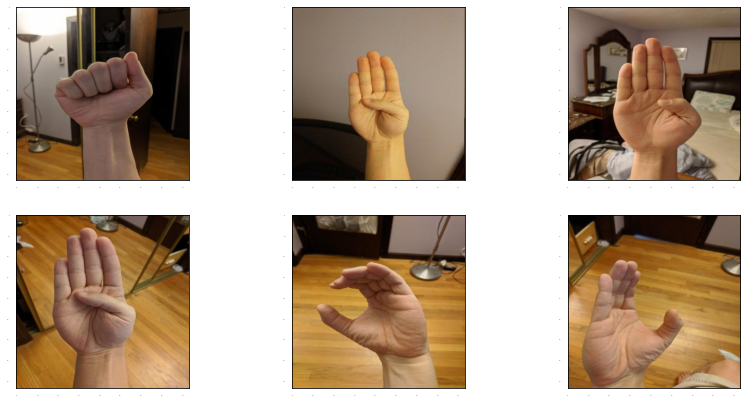

In [10]:
for idx, train_image_np in enumerate(train_images_np[:6]):
    plt.subplot(2, 3, idx+1)
    plt.imshow(train_image_np)
plt.show()

In [11]:
num_classes = 26
category_index = {1:{'id':1, 'name':'a'}, 2:{'id':2, 'name':'b'}, 3:{'id':3, 'name':'c'}, 4:{'id':4, 'name':'d'}, 5:{'id':5, 'name':'e'}, 6:{'id':6, 'name':'f'}, 7:{'id':7, 'name':'g'}, 8:{'id':8, 'name':'h'}, 9:{'id':9, 'name':'i'}, 10:{'id':10, 'name':'j'}, 11:{'id':11, 'name':'k'}, 12:{'id':12, 'name':'l'}, 13:{'id':13, 'name':'m'}, 14:{'id':14, 'name':'n'}, 15:{'id':15, 'name':'o'}, 16:{'id':16, 'name':'p'}, 17:{'id':17, 'name':'q'}, 18:{'id':18, 'name':'r'}, 19:{'id':19, 'name':'s'}, 20:{'id':20, 'name':'t'}, 21:{'id':21, 'name':'u'}, 22:{'id':22, 'name':'v'}, 23:{'id':23, 'name':'w'}, 24:{'id':24, 'name':'x'}, 25:{'id':25, 'name':'y'}, 26:{'id':26, 'name':'z'}}

alp_to_num = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'H':8, 'I':9, 'J':10, 'K':11, 'L':12, 'M':13, 'N':14, 'O':15, 'P':16, 'Q':17, 'R':18, 'S':19, 'T':20, 'U':21, 'V':22, 'W':23, 'X':24, 'Y':25, 'Z':26}

In [12]:
alp_to_num[gt_truth[-1]]

26

In [13]:
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []

In [14]:
for (train_image_np, gt_box_np, truth) in zip(train_images_np, gt_boxes, gt_truth):
    
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image_np, dtype=tf.float32), axis=0))
    
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(alp_to_num[truth] - label_id_offset, dtype=tf.int32)
    print(zero_indexed_groundtruth_classes)
    
    gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_groundtruth_classes, num_classes))
    
print('Done prepping data.')

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dt

In [15]:
gt_classes_one_hot_tensors[0]

<tf.Tensor: shape=(26,), dtype=float32, numpy=
array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

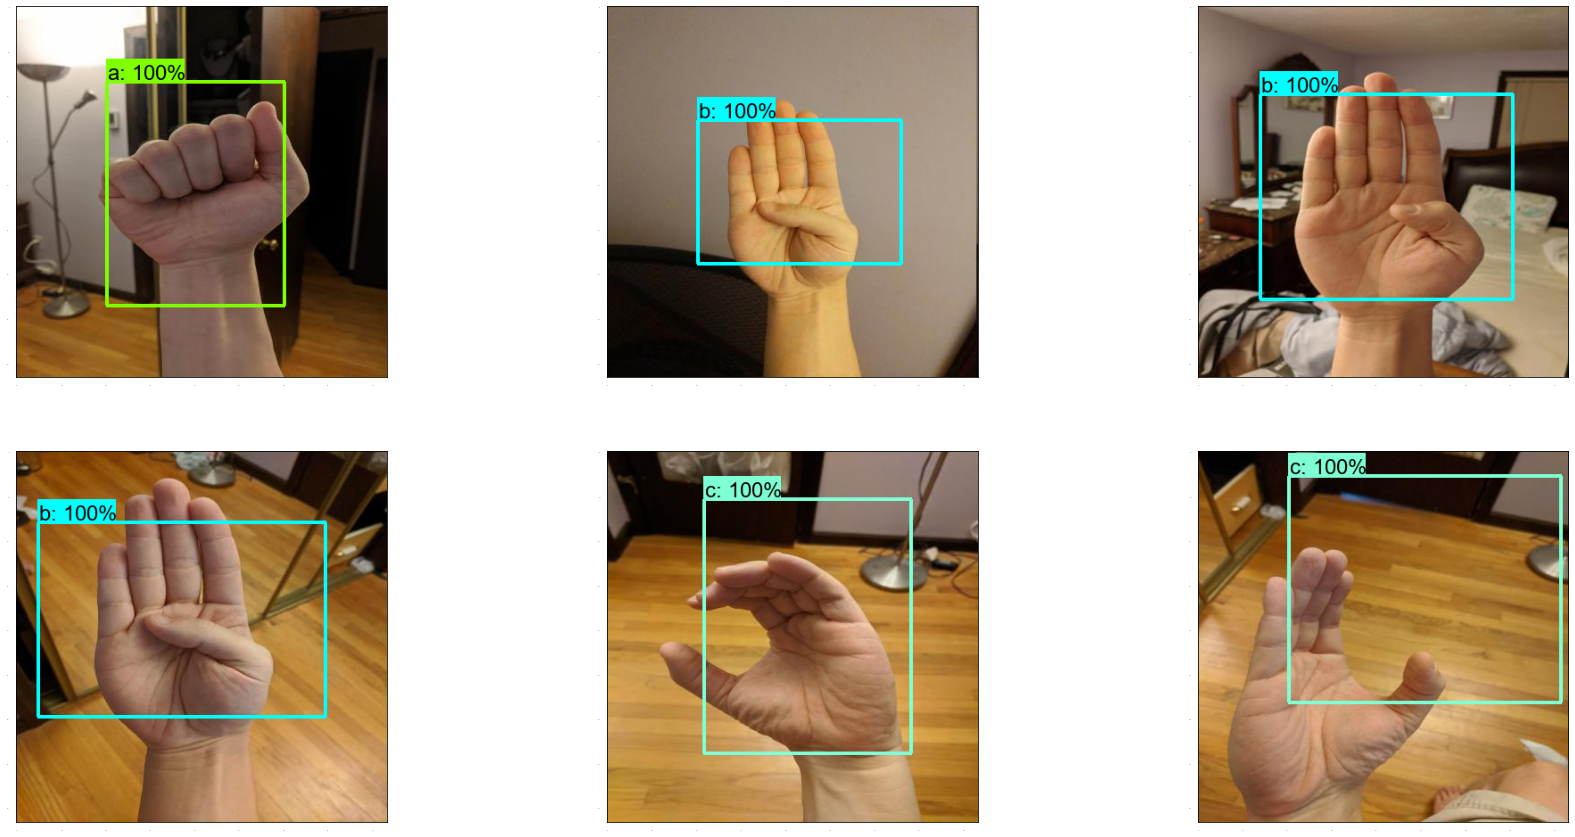

In [16]:

dummy_score = np.array([1.0], dtype=np.float32)

plt.figure(figsize=(30,15))

for idx in range(6):
    plt.subplot(2,3,idx+1)
    
    plot_detections(
    train_images_np[idx],
    gt_boxes[idx],
    [alp_to_num[gt_truth[idx]]],
    dummy_score, category_index)
    
plt.show()

In [17]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 26
pipeline_config = "C:\\Users\\jobin\\models\\research\\object_detection\\configs\\tf2\\ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config"
checkpoint_path = "C:\\Users\\jobin\\models\\research\\object_detection\\test_data\\checkpoint\\ckpt-0"


Building model and restoring weights for fine-tuning...


In [18]:
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(model_config=model_config, is_training=True)

In [19]:
fake_box_predictor = tf.compat.v2.train.Checkpoint(
_base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
_box_prediction_head=detection_model._box_predictor._box_prediction_head,
)

fake_model = tf.compat.v2.train.Checkpoint(
_feature_extractor=detection_model._feature_extractor,
_box_predictor=fake_box_predictor)

In [20]:
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

In [21]:
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Weights restored!


In [22]:
tf.keras.backend.set_learning_phase(True)

batch_size = 0
learning_rate = 0.01
num_batches = 25

trainable_variables = detection_model.trainable_variables
to_fine_tune = []

prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']

for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)
        

C:\Users\jobin\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\backend.py:435: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [23]:
len(to_fine_tune)

4

In [30]:
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
    def train_step_fn(image_tensors,
                 groundtruth_boxes_list,
                 groundtruth_classes_list):
    
        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list)
    
        with tf.GradientTape() as tape:
            preprocessed_images = tf.concat(
              [detection_model.preprocess(image_tensor)[0]
               for image_tensor in image_tensors], axis=0)
            print(preprocessed_images.shape)
        
            prediction_dict = model.predict(preprocessed_images, shapes)
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
            gradients = tape.gradient(total_loss, vars_to_fine_tune)
            optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        return total_loss
    return train_step_fn

In [33]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)

for idx in range(num_batches):
    all_keys = list(range(len(train_images_np)))
    #print(all_keys)
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]
    
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [tf.expand_dims(gt_classes_one_hot_tensors[key], axis=0) for key in example_keys]
    image_tensors = [train_image_tensors[key] for key in example_keys]
    print(image_tensors[0].shape)
    print(gt_classes_list)
    
    total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)
    if idx % 10 == 0:
        print('batch ' + str(idx) + ' of ' + str(num_batches)
        + ', loss=' +  str(total_loss.numpy()), flush=True)
        
print('Done fine-tuning!')

Start fine-tuning!
(1, 416, 416, 3)
[<tf.Tensor: shape=(1, 26), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)>]


ResourceExhaustedError: OOM when allocating tensor with shape[1,640,640,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ResizeBilinear]